# Function Approximation with Neural Networks

One significant use of neural networks is in **approximating** the values of **continuous functions**. Particularly in areas like Deep Reinforcement Learning over continuous/high-dimensional state-spaces. 

For example, **Reinforcement Learning** algorithms like **Deep Q Learning** or **Fitted Value Iteration** can use neural networks to approximate Q functions, policies or value functions.

### References

[1] Cybenko, G. (1989). Approximation by superpositions of a sigmoidal function. Mathematics of Control, Signals, and Systems, 2(4), 303–314. doi:10.1007/bf02551274 

[2] https://en.wikipedia.org/wiki/Backpropagation

## A Universal Approximation Theorem

In the context of Artificial Neural Networks, universal approximation theorems concern the ability of feedforward networks to approximate certain classes of functions. Let us take a look at one specific class of neural networks - those with a single hidden layer of neurons with sigmoidal activation functions.

We say that any function $\sigma$ is sigmoidal if  $$ \sigma (t) \to  \left\{
\begin{array}{ll}
      1\ as\ t \to \infty\\
      0\ as\ t \to -\infty\\
\end{array} 
\right. $$

We let $I_n$ denote the n-dimensional unit cube <br /> The space of continuous functions on $I_n$ is denoted by $C(I_n)$ **[1]**

One **specific theorem** is as following **[1]**:



Let $\sigma$ be any continuous discriminatory function. Then finite sums of the form $$ G(x) = \sum_{j=1}^{N}\alpha_j\sigma(y_j^Tx + \theta_j) $$ are dense in $C(I_n))$. In other words, given any $f \in C(I_n)$ and $\epsilon > 0$, there is a sum, $G(x)$, of the above form for which $$ |G(x)-f(x)| < \epsilon\quad \textrm{for all}\quad x \in I_n$$

<br />
<br />

This theorem is given and proven in **[1]**.

Subsequently, a **lemma** is proven, stating that "**Any bounded, measurable sigmoidal function, $\sigma$, is discriminatory**. In particular, any continuous sigmoidal function is discriminatory."
(The paper also proves a result related to decision functions - i.e. classification - but this is less relevant to us) **[1]**.
<br />

**Therefore,** for an arbitrary precision level, there exists a single-layer neural network (with sigmoidal activation function) that approximates any continuous function on $I_n$.
<br />
<br />

Now, for our practical purposes, this is more of a novelty; the theorem says nothing about the **required network size** or whether approximations can be obtained by **any specific learning algorithm**. 

Other such theorems build up support for the **existence** of neural networks as function approximators but let's look at some data to examine their practical performance under **standard learning algorithms** (i.e. backpropagation), 

## A Parabola

Let's get a basic parabola:


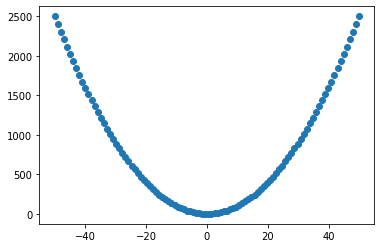

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-50, 50, 100)
y = x**2

plt.scatter(x, y)



Now let's try with a neural network.

### \[Tangent\] A Neural Network from Scratch

As our target problem is fairly basic and doesn't require high-performance, let's attempt making a neural network from scratch.

Here's a basic **Layer class**:

In [2]:
from math import exp


class Layer:
    
    def __init__(self, size):
        self.neurons = []
        self.size = size
        self.next_layer = None
        self.prev_layer = None
        
    def output(self):
        
        result = []
        
        for neuron in self.neurons:
            result.append(neuron.value)
            
        print(result)

Here's a **Dense Layer** (a layer that's fully connected to all the nodes in the previous layer).

It has a function to forward propagate inputs through the network:

In [3]:
class DenseLayer(Layer):
    
    
    def __init__(self, neuron_count, activation_function, prev_layer):
        
        super().__init__(neuron_count)
        
        
        # Handle connection with previous layer
        self.prev_layer = prev_layer
        prev_layer.next_layer = self
        
        # Creates Neurons
        for i in range(neuron_count):
            
            new_neuron = Neuron(activation_function, np.random.rand(prev_layer.size), np.random.rand())
            
            self.neurons.append(new_neuron)
            
            # Connects this neuron in a dense fashion to the previous layer
            for neuron in prev_layer.neurons:
                
                new_neuron.back_conns.append(neuron)
                neuron.forward_conns.append(new_neuron)
                
    def forward_propagate(self):

        for i in self.neurons:
            i.process()
            i.send_forward()

        if self.next_layer:
            self.next_layer.forward_propagate()
            

Here's an **Input Layer**. It stores input values for the neurons and doesn't perform any processing on its neurons.

In [4]:
class InputLayer(Layer):
    
    def __init__(self, input_size):
        
        super().__init__(input_size)
        
        for i in range(input_size):
            self.neurons.append(Neuron())
    
    def forward_propagate(self, input):
        
             
        if len(input) != len(self.neurons):
            print('Input Dimension Error!')
            return
        
        for i in range(len(input)):
            self.neurons[i].value = input[i]
            self.neurons[i].send_forward()
            
        if self.next_layer:
            self.next_layer.forward_propagate()
        

Here's our all-important **Neuron Class**. This actually **performs the activations** and **carries values** to the next layer.

In [5]:


class Neuron:
    
    def __init__(self, activation_function=None, weight=None, bias=None):
        
        self.forward_conns = []
        self.back_conns = []
        self.weight = weight
        self.bias = bias
        self.input = []
        self.activation_function = activation_function
        self.value = None
    
    def process(self):
        
        arr = np.array(self.input)
        
        if len(self.input) == 0:
            print('Error! Uninitialised Node.')
            return
        
        if self.activation_function == None:
            print('No Activation Function')
            return
        
        if arr.shape != self.weight.shape:
            print('Invalid Weight')
            print(self.weight) 
            print(arr)
            return
        
        if self.bias == None:
            print('Invalid Bias')
            return
        
        
        
        
        result = np.dot(arr,self.weight) + self.bias
        self.value = self.activation_function(result)
        
            
    def send_forward(self):
        for neuron in self.forward_conns:
            neuron.input.append(self.value)

And here are our **activation function** implementations - **RELU** and its **derivative**.

In [6]:
def relu(val):
    return max(0,val)
        
def relu_derivative(val):
    if val > 0:
        return 1
    return 0

Let's test out the operation of our network:
This text-network has 4 layers - **Input**, 2 **8-neuron hidden layers**, **1-neuron Output**

In [7]:
first_layer = InputLayer(4)
prev_layer = first_layer
for i in range(2):
    layer = DenseLayer(8, relu, prev_layer)
    prev_layer = layer
last_layer = DenseLayer(1, relu, prev_layer)

In [8]:
first_layer.forward_propagate([1,2,3,4])

In [9]:
first_layer.output()
last_layer.output()

[1, 2, 3, 4]
[65.77272804941441]


So it works simply enough: we put some values in, they get forward propagated, then we get output.

## A Derivation of Backpropagation

Now that we've achieved basic forward propagation with arbitrary activation functions between dense layers, let's consider what our cost function could look like for function approximation.

We're performing a regression-style problem so, like with linear regression, let's try squared error:

**NOTE:** Differing from the theorem above, we target a **RELU activation function** because it helps mitigate certain training issues like **vanishing gradients**. 

Let's outline a derivation ( Wikipedia's **[2]** sigmoidal derivation as a guide):

$$ Let\ R(x)=\left\{
\begin{array}{ll}
      0 & x \leq 0\\
      x & x > 0\\
\end{array} 
\right. \ be\ the\ RELU\ activation\ function$$

Let's use a Least Squares Loss Function (like we would in linear regression)

$$ Let\ L(y,\hat{y}) = (y-\hat{y})^2\ be\ our\ loss\ function,\quad \hat{y}\ is\ the\ network's\ estimate,\quad y\ is\ the\ true\ value $$


$$ Let\ w\ and\ b\ represent\ the\ network's\ weights\ and\ biases\ respectively$$
The output of some neuron j is given by:
$$ o_j = R((\sum_{k=1}^{n}w_{kj}o_{k}) + b_j)$$

Now:

$$ \frac{d R(x)}{dx}= \left\{
\begin{array}{ll}
      0 & x < 0\\
      1 & x > 0\\
      Undefined & x = 0\\
\end{array} 
\right. $$

Now, as we can see, the derivative is not defined at x=0, so in practice we often just assign a 0 or 1 value for it.


Let's now calculate the derivative of the loss function with respect to the weights and biases:

First, the weights (using the chain rule for partial derivatives):

$$ \frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial w_{ij}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial w_{ij}}\quad where\ linear_{j}\ is\ the\ linear\ input\ to\ the\ RELU\ function\ for\ neuron\ j\quad (1)$$

$$ \frac{\partial\ linear_{j}}{\partial w_{ij}} =  \frac{\partial}{\partial w_{ij}}((\sum_{k=1}^{n}w_{kj}o_{k}) + b_j) =  \frac{\partial}{\partial w_{ij}}w_{ij}o_{i} = o_i\quad (2)$$

$$ \frac{\partial o_j}{\partial\ linear_{j}} = \frac{\partial\ R(linear_{j})}{\partial\ linear_{j}} = \left\{\begin{array}{ll}
      0 & linear_{j} < 0\\
      1 & linear_{j} > 0\\
      Undefined & linear_{j} = 0\\
\end{array} 
\right. \quad (shown\ above)\quad (3)$$


Secondly, the biases (using the chain rule for partial derivatives):

$$ \frac{\partial L}{\partial b_{j}} = \frac{\partial E}{\partial o_{j}}\frac{\partial o_{j}}{\partial b_{j}} = \frac{\partial E}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial b_{j}}\quad (4)$$

$$ \frac{\partial\ linear_{j}}{\partial b_{j}} =  \frac{\partial}{\partial b_{j}}((\sum_{k=1}^{n}w_{kj}o_{k}) + b_j) =  1\quad (5)$$

**NOTE**:  The output layer has the identity function as an activation so $\frac{\partial o_{t}}{\partial\ linear_{t}} = 1$ for any neuron $t$ in the output layer).


Now, here comes the genius of backpropagation:

In the last (output) layer - a single node for our network,   $ o_j = \hat{y} $

So: 

$$ \frac{\partial L}{\partial o_j} = \frac{\partial L}{\partial \hat{y}} = \frac{\partial }{\partial \hat{y}}(\frac{1}{2}(y-\hat{y})^2) = \hat{y} - y\quad (6)$$

Now, if we consider j being a neuron in any other layer:

L is still a function of $ o_j $ because L is dependent on all the neurons receiving input from j:

So:

$$ \frac{\partial L}{\partial o_j} = \frac{\partial L(linear_a,linear_b, ...)}{\partial o_j}\ where\ neurons\ in\ P=\{ a,b,...\}\ receive\ input from\ neuron\ j $$

Now, the linear components are all functions of $o_j$ so are dependent on one another.

Therefore we need to take the **total derivative** to find this:

$$ \frac{\partial L}{\partial o_j} = \sum_{p \in P}(\frac{\partial L}{\partial linear_p}\frac{\partial linear_p}{\partial o_j}) = \sum_{p \in P}(\frac{\partial L}{\partial o_p}\frac{\partial o_p}{\partial linear_p}\frac{\partial linear_p}{\partial o_j}) = \sum_{p \in P}(\frac{\partial L}{\partial o_p}\frac{\partial o_p}{\partial linear_p}w_{jp}) \quad (7)$$

So this term is recursively dependent on those of neurons in P.

Now we have everything we need to find our partial derivatives for gradient descent.

**For the weights:**

Using Equations, 1,2,3,4,5:

$$\frac{\partial L}{\partial w_{ij}}  = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial w_{ij}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}o_i$$

And we assign:

$$\delta_j = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}} =   
\left\{
\begin{array}{ll}
      (o_j-\hat{y}) & if\ j\ is\ an\ output\ neuron\\
      (\sum_{p\in P}(\frac{\partial L}{\partial o_p}\frac{\partial o_p}{\partial linear_p}w_{jp}))\frac{d R(o_j)}{do_j} & if\ j\ is\ an\ inner\ neuron\\
\end{array} 
\right. 
= \left\{
\begin{array}{ll}
      (o_j-\hat{y}) & if\ j\ is\ an\ output\ neuron\\
      (\sum_{p\in P}(w_{jp}\delta_{p}))\frac{d R(o_j)}{do_j} & if\ j\ is\ an\ inner\ neuron\\
\end{array} 
\right. 
$$


**Let's do the same with biases:**

$$\frac{\partial L}{\partial b_{j}}  = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}\frac{\partial\ linear_{j}}{\partial b_{j}} = \frac{\partial L}{\partial o_{j}}\frac{\partial o_{j}}{\partial\ linear_{j}}$$

So:

$$\frac{\partial L}{\partial w_{ij}} = o_i\delta_j $$

$$\frac{\partial L}{\partial b_{j}} = \delta_j $$

Now we can perform gradient descent to improve our neural network over time by 'back-propagating' through the network and adjusting weights/biases proportional to the negative of these derivatives. The constand of proportionality is called the **'learning rate'**.

## Putting it All Together

Here's our main **Layer Class** once again. We've added a **layer_info** method to help with debugging

In [38]:
from math import exp
from math import sqrt

class Layer:
    
    def __init__(self, size):
        self.neurons = []
        self.size = size
        self.next_layer = None
        self.prev_layer = None
        
    def output(self):
        
        result = []
        
        for neuron in self.neurons:
            result.append(neuron.result)
            
        print(result)
        
    def layer_info(self):
        
        if self.prev_layer == None:
            print('Input Layer')
            return
        
        for i in range(len(self.neurons)):
            print('%d: %f' % (i, self.neurons[i].bias))
            print(self.neurons[i].weight)
                

Our Dense Layer now has a **back_propagate** method to perform the **back propagation calculations** and a **store_weights** method to allow **updating** each neuron's parameters **in batches**.

In [39]:
class DenseLayer(Layer):
    
    
    def __init__(self, neuron_count, activation_function, prev_layer):
        
        super().__init__(neuron_count)
        
        
        # Handle connection with previous layer
        self.prev_layer = prev_layer
        prev_layer.next_layer = self
        
        # Creates Neurons
        for i in range(neuron_count):
            
            # This is a half-hearted attempt at Xavier initialization. 
            # We don't have the number of nodes in the next layer yet so just take fan_in as a poor approximation.
            fan_in = len(prev_layer.neurons)**2
            coeff = sqrt(6)/sqrt(fan_in)
            
            new_neuron = Neuron(activation_function, (np.random.rand(prev_layer.size)-0.5)*2*coeff, (np.random.rand()-0.5))
            
            self.neurons.append(new_neuron)
            
            # Connects this neuron in a dense fashion to the previous layer
            for neuron in prev_layer.neurons:
                
                new_neuron.back_conns.append(neuron)
                neuron.forward_conns.append(new_neuron)
                
    def forward_propagate(self,layer):
        

        for i in self.neurons:
            i.process()
            i.send_forward()

        if self.next_layer:
            self.next_layer.forward_propagate(layer+1)
            
    def back_propagate(self,true):
        
        for i in range(len(self.neurons)):
            self.neurons[i].backprop(true,i)
            
        self.prev_layer.back_propagate(true)
        
    def store_weights(self):
        
        for neuron in self.neurons:
            neuron.store_weights()
            
        if self.next_layer != None:
            self.next_layer.store_weights()

The **Input Layer class** now has placeholder **back_propagate** and **store_weights** methods which allow these actions to be called recursively for the next layers.

In [40]:
class InputLayer(Layer):
    
    def __init__(self, input_size):
        
        super().__init__(input_size)
        
        for i in range(input_size):
            self.neurons.append(Neuron())
    
    def forward_propagate(self, input):
        
        
        if len(input) != len(self.neurons):
            print('Input Dimension Error!')
            return
        
        for i in range(len(input)):
            self.neurons[i].value = input[i]
            self.neurons[i].send_forward()
            
        if self.next_layer:
            self.next_layer.forward_propagate(1)
            
    # The input layer doesn't need to perform backprop
    def back_propagate(self, true):
        return
    
    def store_weights(self):
        if self.next_layer != None:
            self.next_layer.store_weights()

Our **Neuron Class** now has methods to **backpropagate** and to **update the weights** after **a batch** of samples has been entered.

In [136]:
class Neuron:
    
    def __init__(self, activation_function=None, weight=None, bias=None):
        
        self.forward_conns = []
        self.back_conns = []
        self.weight = weight
        self.bias = bias
        self.input = []
        self.saved_input = None
        self.activation_function = activation_function
        self.value = None
        self.delta = None
        self.delta_weights = []
        self.delta_bias = 0
    
    def process(self):
        arr = np.array(self.input)
        #print(self.input)
        if len(self.input) == 0:
            print('Error! Uninitialised Node.')
            return
        
        if self.activation_function == None:
            print('No Activation Function')
            return
        
        if arr.shape != self.weight.shape:
            print('Invalid Weight')
            print(self.weight) 
            print(arr)
            return
        
        if self.bias == None:
            print('Invalid Bias')
            return
        
        
        
        self.result = np.dot(arr,self.weight) + self.bias
        self.saved_input = self.input
        self.input = []
        self.value = self.activation_function(self.result)
        
    def backprop(self, true, j):
        if len(self.forward_conns) == 0:
            self.delta = (self.value-true) # removed *self.value*(1-self.value) because output is identity function
            
        else:
            delta_sum = 0
            for i in self.forward_conns:
                delta_sum += i.delta*i.weight[j]
            self.delta = delta_sum*relu_derivative(self.value)
            
        
        # Max and mins used for clipping gradients
        
        for i in range(len(self.weight)):
            if len(self.delta_weights) > i: 
                self.delta_weights[i] += self.saved_input[i]*self.delta*-1*LEARNING_RATE
                #self.delta_weights[i] = max(-100000,min(self.delta_weights[i],100000))
                
            else:
                #self.delta_weights.append(max(-100000,min(100000,self.saved_input[i]*self.delta*-1*LEARNING_RATE)))
                self.delta_weights.append(self.saved_input[i]*self.delta*-1*LEARNING_RATE)
            
        self.delta_bias += -1*LEARNING_RATE*self.delta
            
            
    def send_forward(self):
        for neuron in self.forward_conns:
            neuron.input.append(self.value)
    
    def store_weights(self):
        
        if len(self.delta_weights) == 0:
            print('Invalid stored weights')
            return
        
        self.weight = np.add(self.weight,np.array(self.delta_weights))
        self.bias += self.delta_bias
        self.delta_bias = 0
        self.delta_weights = []
            

And finally, our **identity function** - the **activation function for the output layer**.

In [137]:
def identity(val):
    return val

### Training Our Model

Now it's time to **make our model**, **train** and **test**:

In [165]:
LEARNING_RATE = 0.1

In [172]:
import random


def train_and_test(epochs,first_layer, last_layer, domain_min, domain_max, test_set):
    loss = []

    # Create a large point dataset.
    x = np.random.random_sample(10000)*(domain_max-domain_min) + domain_min
    y = np.asarray([i**2.0 for i in x])

    # Calculate min and max x&y values to normalise them between 0 and 1.
    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)

    # Define normalised 'true value' of parabola.
    a = lambda x: (x**2 - y_min)/(y_max-y_min)

    # Train for some number of epochs.
    for i in range(epochs):



        # Select a random element from our dataset
        x_val = x[random.randint(0,len(x)-1)]

        # Normalise x to between 0 and 1.
        x_norm = (x_val-x_min)/(x_max-x_min)

        # Propagate normalised x through the network.
        first_layer.forward_propagate([x_norm])
        last_layer.back_propagate(a(x_val))

        # Store losses to plot later
        loss.append((last_layer.neurons[0].value-a(x_val))**2)

        # Update parameters in batches of size 10.
        if (i%10):
            first_layer.store_weights()

    # Plot the loss at each epoch.
    plt.plot(np.array(loss))
    plt.show()

    test_outputs = []
    total_error = 0
    for i in test_set:
        first_layer.forward_propagate([(i-x_min)/(x_max-x_min)])
        test_outputs.append(last_layer.neurons[0].result*(y_max-y_min) + y_min)
        total_error += ((last_layer.neurons[0].result*(y_max-y_min) + y_min) - i**2)**2

    rmse = sqrt(total_error/len(test_set))
    print('RMSE:',rmse)

    plt.scatter(test_set,test_outputs)
    plt.scatter(x,y)

Let's test a variety of models, applying the same test set to ensure consistent testing across models:

In [179]:
test_set = np.random.random_sample(10000)*(100-(-100)) + -100

 ### Different Layer Counts
 (all with 10000 epochs and a [-100,100] range)

**2 Layer Network**

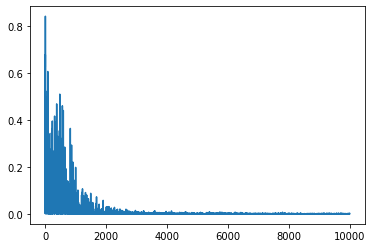

RMSE: 351.62143527187743


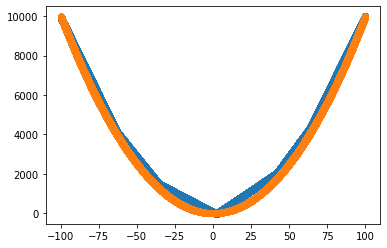

In [180]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(2):
    layer = DenseLayer(10, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(10000, first_layer, last_layer, -100, 100, test_set)

**3 Layer Network**

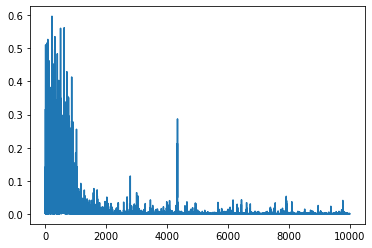

RMSE: 254.88397801008884


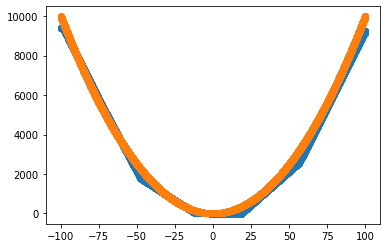

In [181]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(3):
    layer = DenseLayer(10, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(10000, first_layer, last_layer, -100, 100, test_set)

**5 Layer Network**

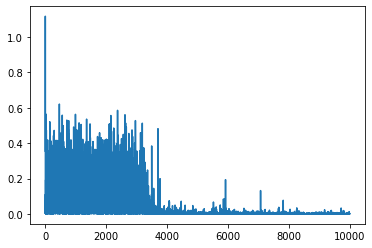

RMSE: 279.7101928762151


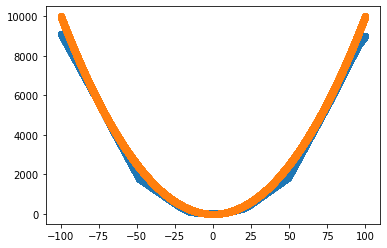

In [182]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(5):
    layer = DenseLayer(10, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(10000, first_layer, last_layer, -100, 100, test_set)

Intereresting! The smallest network converges fairly quickly but has the worst **RMSE** (Root Mean Squared Error). 

The **3-layer network** performs even **better**. However, the **5-layer network** isn't the best and its **loss curve certainly looks weird**.

Let's give them **more epochs** and see what happens:

**2 Layer Network**

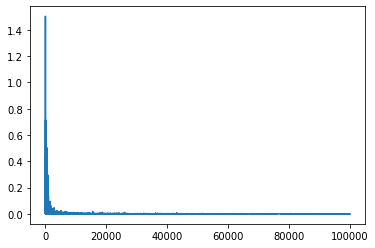

RMSE: 77.22335807530628


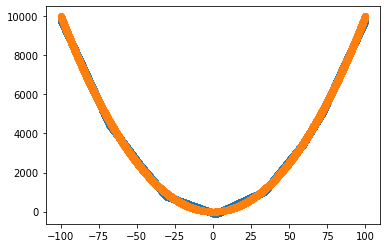

In [186]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(2):
    layer = DenseLayer(10, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(100000, first_layer, last_layer, -100, 100, test_set)

**3 Layer Network**

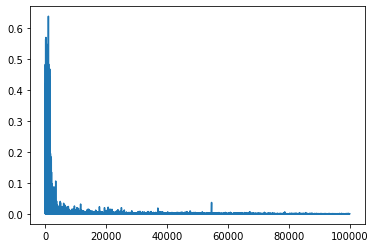

RMSE: 67.52232877792288


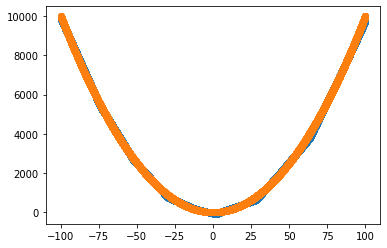

In [187]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(3):
    layer = DenseLayer(10, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(100000, first_layer, last_layer, -100, 100, test_set)

**5 Layer Network**

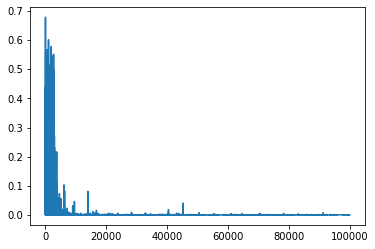

RMSE: 45.372004671392645


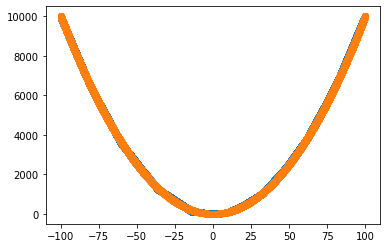

In [188]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(5):
    layer = DenseLayer(10, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(100000, first_layer, last_layer, -100, 100, test_set)

There we go! Although the fatter tail on the loss curve indicates a longer time to converge, the larger network reaches a lower RMSE as it has more parameters and more neurons.

### Layer Width

Let's test this with layer widths.

**10-Neuron Layers**

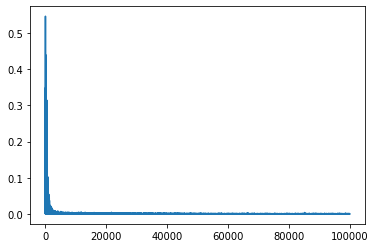

RMSE: 76.56017070764071


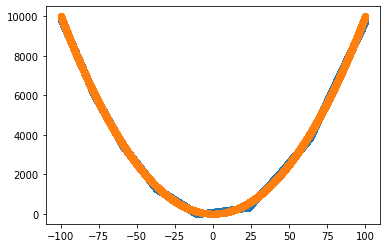

In [192]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(2):
    layer = DenseLayer(10, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(100000, first_layer, last_layer, -100, 100, test_set)

**30-Neuron Layers**

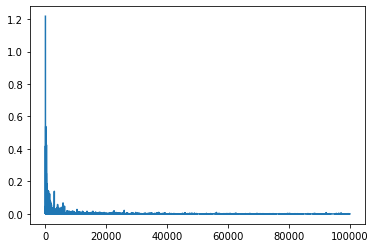

RMSE: 73.65268831358105


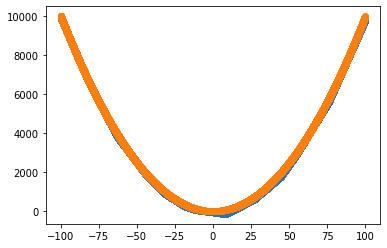

In [193]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(2):
    layer = DenseLayer(30, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(100000, first_layer, last_layer, -100, 100, test_set)

**5-Neuron Layers**

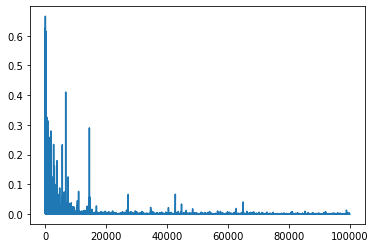

RMSE: 45.10701229203018


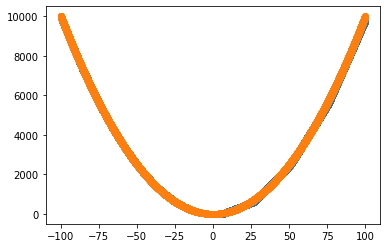

In [194]:
# Input of a single number
first_layer = InputLayer(1)

# Creates 2 Dense RELU Layers of 10 neurons
prev_layer = first_layer
for i in range(2):
    layer = DenseLayer(100, relu, prev_layer)
    prev_layer = layer


# Output of a single number
last_layer = DenseLayer(1,identity,prev_layer)
train_and_test(100000, first_layer, last_layer, -100, 100, test_set)

Wow that model took a long time to train! However, once again, it performs much better than the others because the increased layer-width allows modelling more complex relationships.

## Tweaks and Debugging

An important thing to recognise is what isn't included in this notebook - **Debugging**:

Here's a list of issues (and attempted solutions) encountered while creating the network:
- Exploding Gradients -> Try clipping the gradients to a certain range
- Vanishing Gradients -> Switch from sigmoid to RELU & initialise neurons better.
- Various Programming Errors -> Write better code
- Stagnant Loss Function -> Normalise Inputs (this was decided after testing various fixes)

And here's a list of debugging strategies (with no commentary of their effectiveness):
- Training a model using keras/sklearn and comparing outputs at various stages
- Stepping through propagations on paper by hand
- Trying to tweak various hyperparameters - layer size, layer count, learning rate
- Switching back and forth between RELU/Sigmoid to compare how they get things wrong


As you can probably tell, this process is a far cry from the plug-and-play simplicity of logistic regression. And yes, using established frameworks with better optimisers makes everything easier, but the increased complexity is still evident.

## Final Notes

A key takeaway is this:

**Neural Networks** are **powerful tools** when you have enough data for them. <br /> However, **making more assumptions/observations** about the data often allows the choice of a **simpler, more specialised model** - e.g. GLMs, Logistic Regression, Decision trees, Ensemble Methods etc. 

And next time you need a parabola, **don't whip out tensorflow**. Surprisingly, **Machine Learning** isn't the solution for ***everything***